In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from nilearn import image
from nilearn.image import binarize_img
import seaborn as sns

# Homemade functions

In [2]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func


## Load and check Cartmell et al. (2019) NAc Probabilistic Atlas.


In [3]:


# Define path for each segment of the atlas. 
LH_core = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/lh-presumed-core.nii.gz"
RH_core = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/rh-presumed-core.nii.gz"
LH_shell = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/lh-presumed-shell.nii.gz"
RH_shell = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/rh-presumed-shell.nii.gz"

NAcc_files = [LH_core, RH_core, LH_shell, RH_shell]
NAcc_core_files = [LH_core, RH_core]
NAcc_shell_files = [LH_shell, RH_shell]

# Merge files into single atlas. 
NAcc_imgs = image.load_img(NAcc_files, wildcards=True)
NAcc_atlas = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs)
NAcc_atlas_masker = NiftiMapsMasker(
        maps_img=NAcc_atlas,
        allow_overlap=True)

NAcc_imgs_core = image.load_img(NAcc_core_files, wildcards=True)
NAcc_atlas_core = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs_core)

NAcc_imgs_shell = image.load_img(NAcc_shell_files, wildcards=True)
NAcc_atlas_shell = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs_shell)


In [4]:

NAcc_atlas_binary = binarize_img(NAcc_atlas)

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/image.py:1071: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


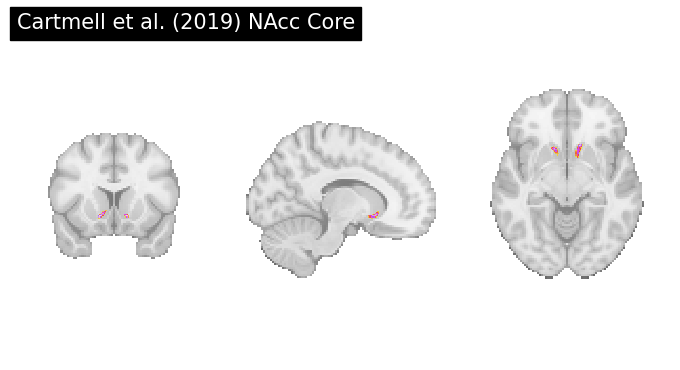

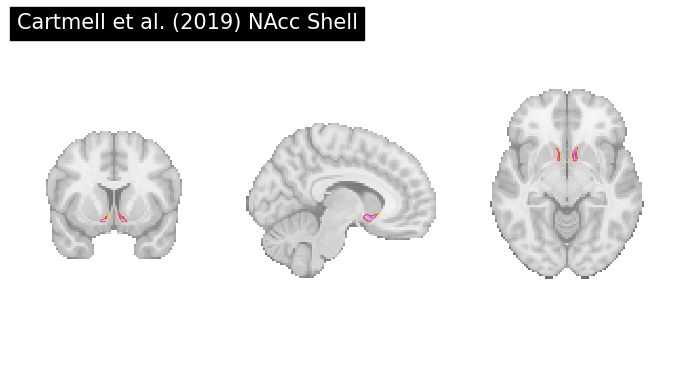

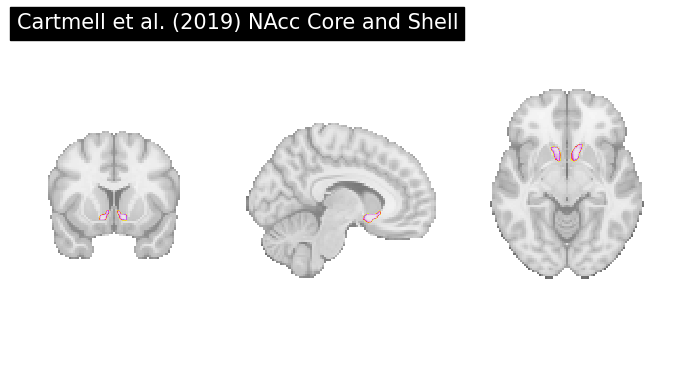

In [5]:
# Plot the atlases.
plot_roi(NAcc_atlas_core, cut_coords=None, title="Cartmell et al. (2019) NAcc Core", annotate=False, draw_cross=False)
plot_roi(NAcc_atlas_shell, cut_coords=None, title="Cartmell et al. (2019) NAcc Shell", annotate=False, draw_cross=False)
plot_roi(NAcc_atlas, cut_coords=None, title="Cartmell et al. (2019) NAcc Core and Shell", annotate=False, draw_cross=False)


## Load fMRI files. 

In [20]:
# Load the functional files.
nii_files = glob(os.path.join(os.getcwd(), "*Gambling*.nii*"))
nii_files = sorted(nii_files)
print(nii_files)

# Load the confounds file.
confounds_files = glob(os.path.join(os.getcwd(), "*Gambling*confounds*"))
confounds_files = sorted(confounds_files)
print(confounds_files)

useful_cols = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

confounds_files = [pd.read_csv(file, usecols=useful_cols, sep="\t") for file in confounds_files]

# Load the events file.
events_files = glob(os.path.join(os.getcwd(), "*Gambling*events*"))
events_files = sorted(events_files)
print(events_files)


['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_desc-confounds_timeseries.tsv', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_desc-confounds_timeseries.tsv']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_events.tsv', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_events.tsv']


## Create GLM model.

In [25]:
# Create GLM object. 
fmri_glm = FirstLevelModel(
    t_r=2,
    #noise_model="ols",
    standardize=True,
    hrf_model="spm",
    drift_model="cosine",
    high_pass= 1/128,
    slice_time_ref=0.5,
    #mask_img=NAcc_atlas_masker,
    smoothing_fwhm = 4)



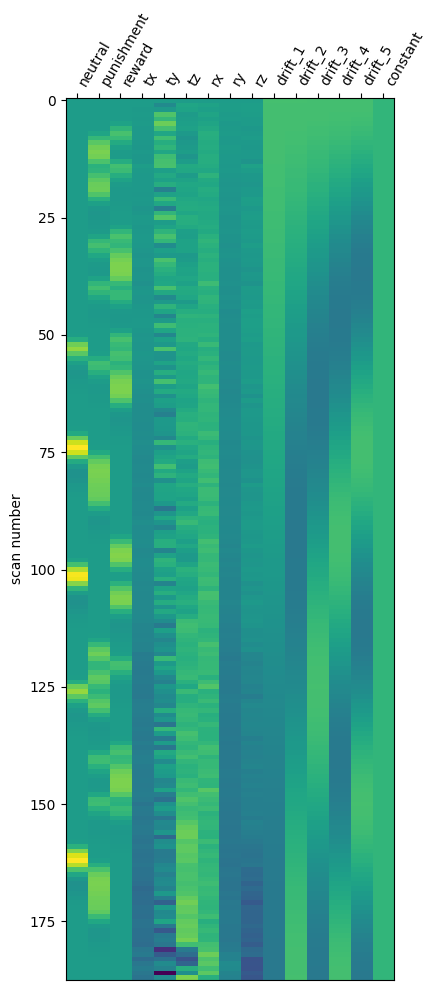

In [26]:
# Fit GLM model. Note it requires as input the fmri file, the events dataframe, and the confounds dataframe. 
fmri_glm_gamble = fmri_glm.fit(nii_files, events_files, confounds_files)

plot_design_matrix(fmri_glm_gamble.design_matrices_[0])

plt.show()

/var/folders/0z/1yt2h6410kb7_mgghf4q28z00000gn/T/ipykernel_1218/759734227.py:4: UserWarning: One contrast given, assuming it for all 2 runs
  reward_minus_punishment_z_map = fmri_glm_gamble.compute_contrast(contrast_def=reward_minus_punishment, stat_type="t", output_type="z_score")
/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 4.804360206318342. But, you have given threshold=inf.
  stat_img = threshold_img(


FDR p<0.05 threshold: inf


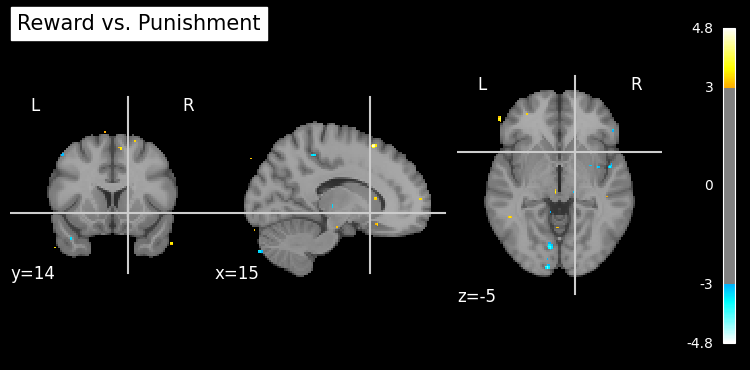

In [27]:
# Create the orthogonal contrast to the create image. Note, the sum of all elements equals zero.
reward_minus_punishment = "+1*reward-1*neutral"

reward_minus_punishment_z_map = fmri_glm_gamble.compute_contrast(contrast_def=reward_minus_punishment, stat_type="t", output_type="z_score")

reward_minus_punishment_thresholded_map, threshold = threshold_stats_img(reward_minus_punishment_z_map, alpha=0.05, height_control="fdr", cluster_threshold=0)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    reward_minus_punishment_z_map,
    threshold=3,#threshold,
    cut_coords=[15, 14, -5],
    black_bg=True,
    title="Reward vs. Punishment"
)
plt.show()